In [2]:
from cil.framework import ImageGeometry
from cil.utilities.jupyter import islicer
from cil.utilities.display import show2D, show_geometry
from cil.processors import CentreOfRotationCorrector, TransmissionAbsorptionConverter, RingRemover, Padder, Slicer
from cil.recon import FBP
from cil.io import NEXUSDataWriter
from cil.io.utilities import HDF5_utilities
import numpy as np
import os
import hdf5plugin
from cil.framework import AcquisitionGeometry, AcquisitionData
import matplotlib.pyplot as plt

In [3]:
filename = '/data/ESRF/Wedgescan_Iterative_ASSB/InSitu-LPSCL-20Ton-30Min_0001.h5'#
angles = HDF5_utilities.read(filename, '/4.1/measurement/hrsrot')
ds_metadata = HDF5_utilities.get_dataset_metadata(filename, '4.1/instrument/pco2linux/data')

In [4]:
roi = [slice(None), slice(300, 1100), slice(None)]
source_sel=tuple(roi)

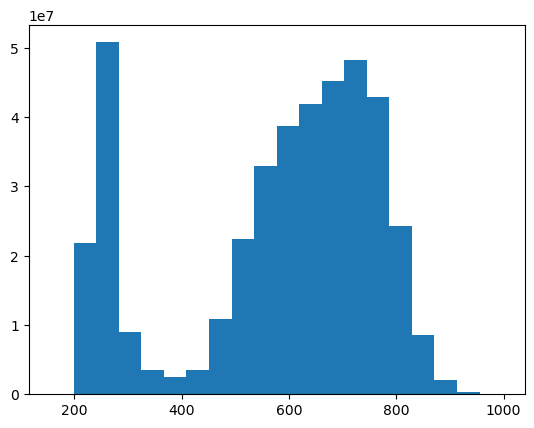

In [5]:
i =10
filename = '/data/ESRF/Wedgescan_Iterative_ASSB/pco2linux_{0:04}.h5'.format(i)
ds_arr = HDF5_utilities.read(filename, 'entry_0000/measurement/data', source_sel).squeeze()
ds_arr[ds_arr>1000] = np.mean(ds_arr)
l = np.min(ds_arr)
u = np.max(ds_arr)
plt.hist(np.ravel(ds_arr), bins=np.arange(l,u,int((u-l)/20)))
islicer(ds_arr)

In [6]:
filename = '/data/ESRF/Wedgescan_Iterative_ASSB/flats.h5'#
HDF5_utilities.print_metadata(filename, '/entry_0000/measurement', 2)
HDF5_utilities.get_dataset_metadata(filename, 'entry_0000/measurement/data')
flats = HDF5_utilities.read(filename, 'entry_0000/measurement/data', tuple(source_sel))
flat = np.mean(flats, axis = 0) #median?


filename = '/data/ESRF/Wedgescan_Iterative_ASSB/darks.h5'#
HDF5_utilities.print_metadata(filename, 'entry_0000/measurement', 2)
HDF5_utilities.get_dataset_metadata(filename, 'entry_0000/measurement/data')
darks = HDF5_utilities.read(filename, 'entry_0000/measurement/data', tuple(source_sel))
dark = np.mean(darks, axis = 0) 

	 - data : <HDF5 dataset "data": shape (60, 2160, 2560), type "<i4">
			 - interpretation : image
	 - data : <HDF5 dataset "data": shape (20, 2160, 2560), type "<i4">
			 - interpretation : image


In [7]:
projections = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
data = np.zeros((3000, roi[1].stop-roi[1].start, ds_metadata['shape'][2]))
for i in projections:
    filename = '/data/ESRF/Wedgescan_Iterative_ASSB/pco2linux_{0:04}.h5'.format(i)
    print(filename)
    ds_arr = HDF5_utilities.read(filename, 'entry_0000/measurement/data', source_sel).squeeze()
    ds_arr[ds_arr>1000] = np.mean(ds_arr) ### this isn't right - how should I be doing this?
    data[i*200:i*200+200] = ds_arr
flat = flat - dark
data_norm = (data - dark)/ flat

/data/ESRF/Wedgescan_Iterative_ASSB/pco2linux_0000.h5
/data/ESRF/Wedgescan_Iterative_ASSB/pco2linux_0001.h5
/data/ESRF/Wedgescan_Iterative_ASSB/pco2linux_0002.h5
/data/ESRF/Wedgescan_Iterative_ASSB/pco2linux_0003.h5
/data/ESRF/Wedgescan_Iterative_ASSB/pco2linux_0004.h5
/data/ESRF/Wedgescan_Iterative_ASSB/pco2linux_0005.h5
/data/ESRF/Wedgescan_Iterative_ASSB/pco2linux_0006.h5
/data/ESRF/Wedgescan_Iterative_ASSB/pco2linux_0007.h5
/data/ESRF/Wedgescan_Iterative_ASSB/pco2linux_0008.h5
/data/ESRF/Wedgescan_Iterative_ASSB/pco2linux_0009.h5
/data/ESRF/Wedgescan_Iterative_ASSB/pco2linux_0010.h5
/data/ESRF/Wedgescan_Iterative_ASSB/pco2linux_0011.h5
/data/ESRF/Wedgescan_Iterative_ASSB/pco2linux_0012.h5
/data/ESRF/Wedgescan_Iterative_ASSB/pco2linux_0013.h5
/data/ESRF/Wedgescan_Iterative_ASSB/pco2linux_0014.h5


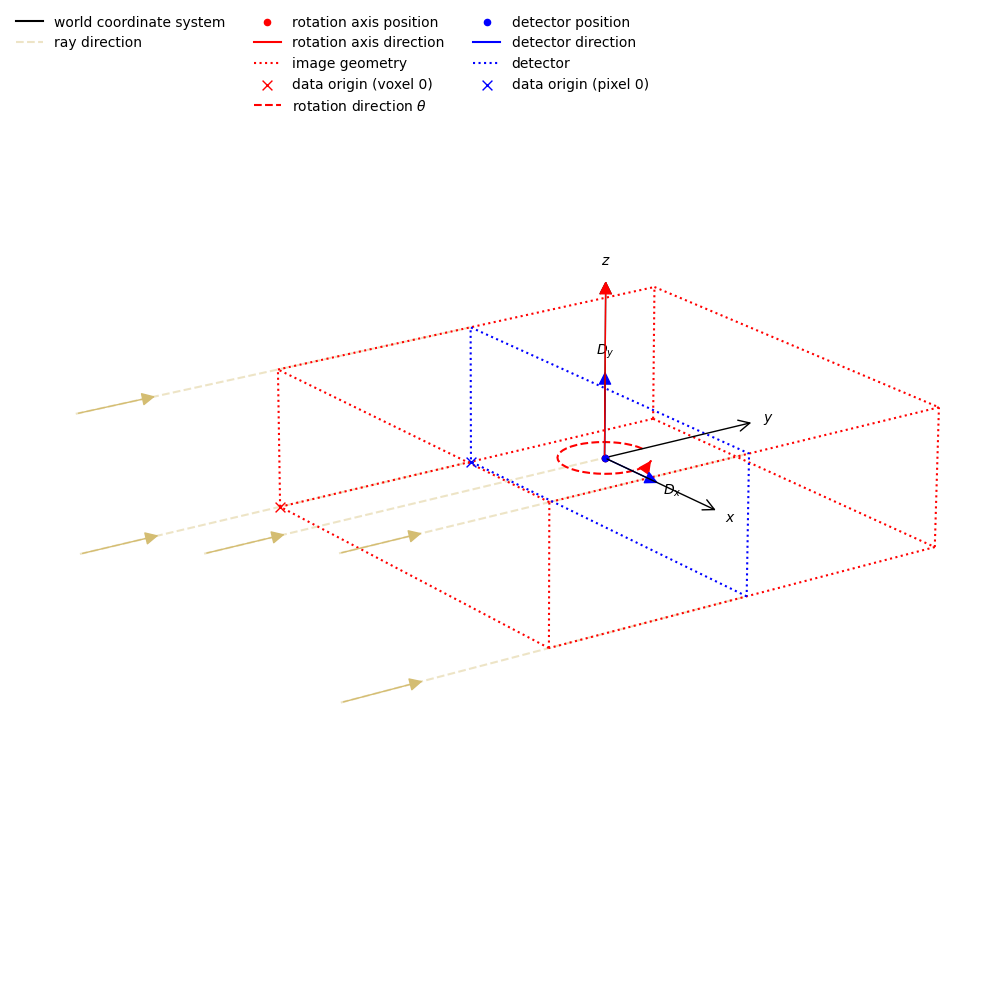

In [8]:
ag = AcquisitionGeometry.create_Parallel3D().set_panel([np.shape(data)[2],np.shape(data)[1]]).set_angles(angles)
show_geometry(ag)
data = AcquisitionData(data_norm.astype(np.float32), geometry=ag, deep_copy=False)
islicer(data)


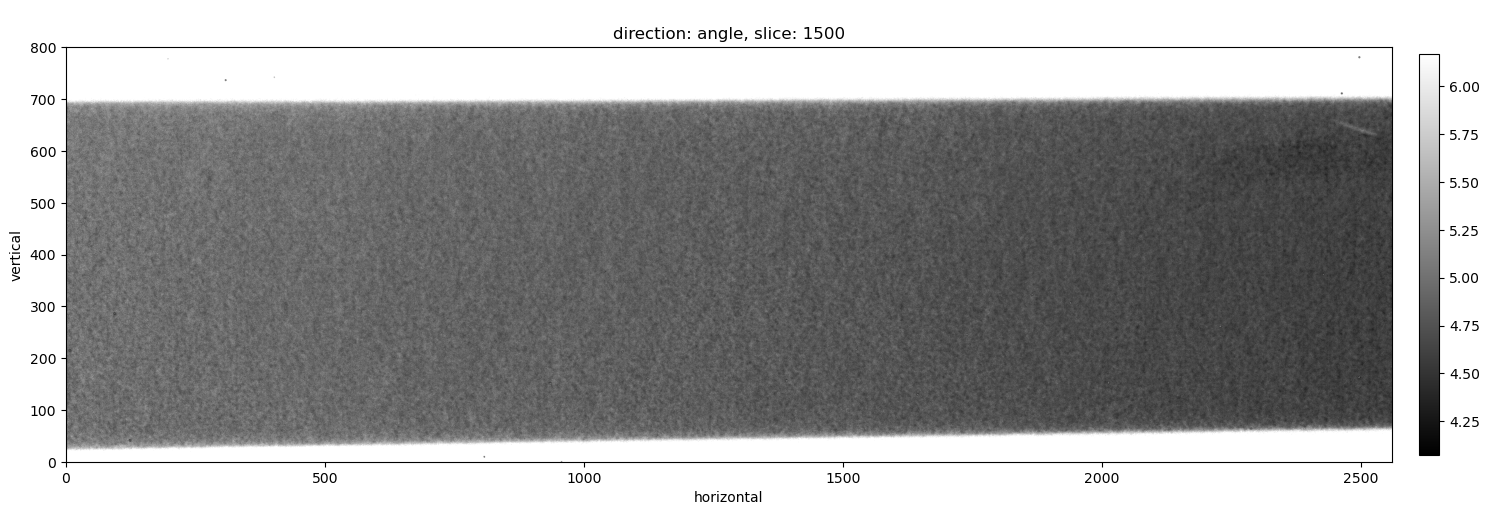

In [9]:
processor = TransmissionAbsorptionConverter(min_intensity=0.0021)
processor.set_input(data)
data = processor.get_output()
show2D(data)

In [10]:
data_wedge = Slicer(roi={'angle': (300, 2710, 1)})(data)
islicer(data_wedge, direction='vertical')

In [12]:
vertical = 400
data_slice = data_wedge.get_slice(vertical=vertical)

Finish Ring Remover


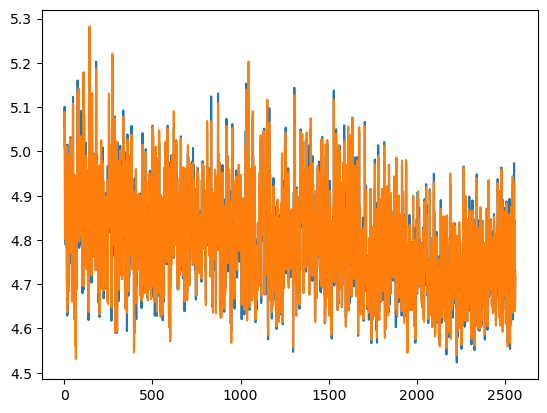

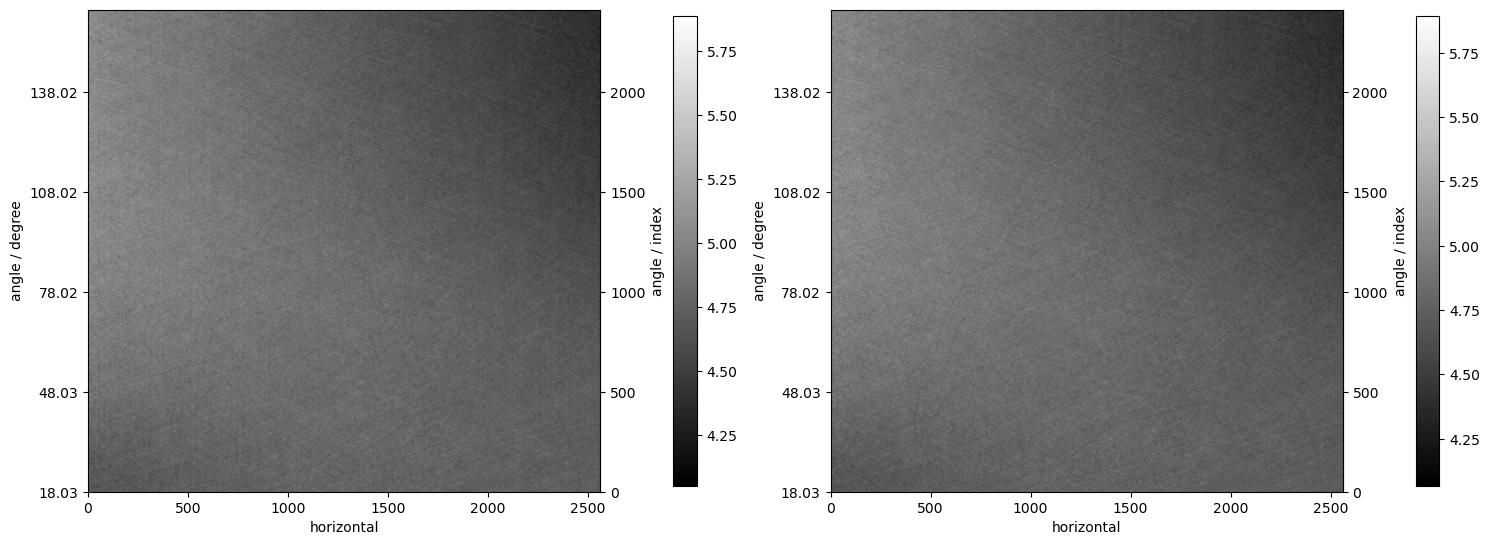

In [13]:

data_slice.geometry.set_centre_of_rotation(12, distance_units='pixels')

ag2d = data_slice.geometry
ig2d = ag2d.get_ImageGeometry()

# data_rr = rem.remove_all_stripe(data_slice.as_array(), snr=3.0, la_size=3, sm_size=3)
# data_rr = AcquisitionData(data_rr.astype(nfp.float32), geometry=ag2d, deep_copy=False)

r = RingRemover(8,'db20', 1.5)
r.set_input(data_slice)
data_rr = r.get_output()

plt.plot(data_slice.array[500,:])
plt.plot(data_rr.array[500,:])

show2D([data_slice, data_rr])

FBP recon

Input Data:
	angle: 2410
	horizontal: 2560

Reconstruction Volume:
	horizontal_y: 2560
	horizontal_x: 2560

Reconstruction Options:
	Backend: tigre
	Filter: ram-lak
	Filter cut-off frequency: 1.0
	FFT order: 13
	Filter_inplace: False
	Split processing: 0

Reconstructing in 1 chunk(s):



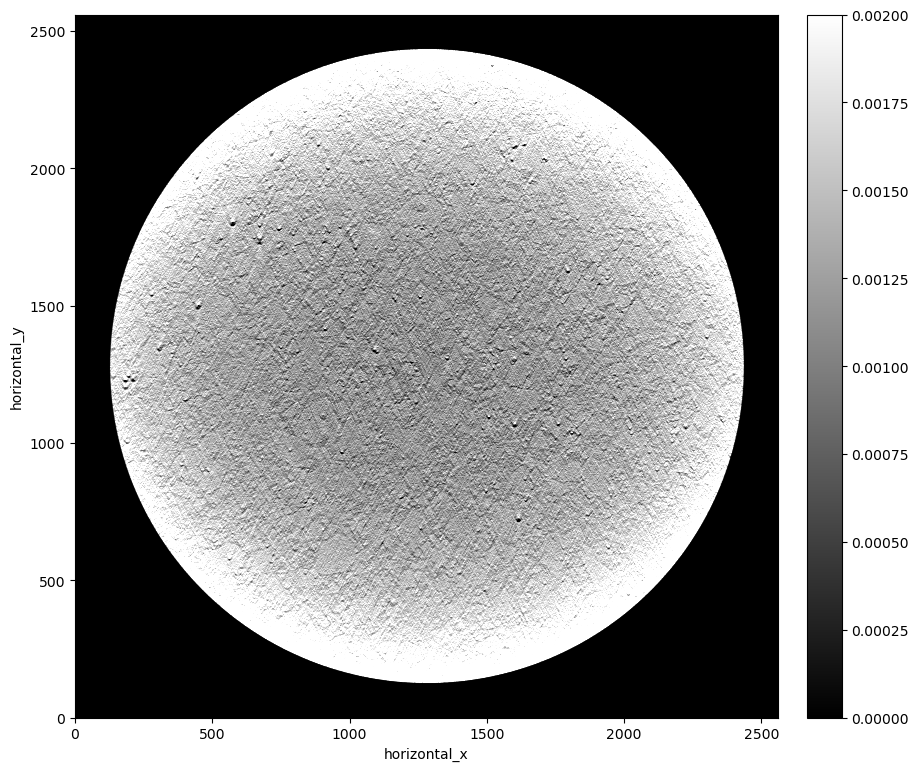

In [15]:
reco = FBP(data_rr).run()
reco.apply_circular_mask(0.9)
show2D(reco, fix_range = (0.00, 0.002))